# **Набор данных для маркетингового A/B-тестирования** 
Маркетинговые компании хотят проводить успешные кампании, но рынок сложен, и могут подойти несколько вариантов. Поэтому обычно они настраивают A/B-тесты, то есть рандомизированный процесс экспериментирования, в котором две или более версии переменной (веб-страница, элемент страницы, баннер и т. д.) одновременно показываются разным сегментам людей, чтобы определить, какая версия оказывает максимальное влияние и улучшает бизнес-показатели.

Компании заинтересованы в ответе на два вопроса:

1. -Будет ли кампания успешной?
1. -Если кампания окажется успешной, какая часть этого успеха может быть связана с рекламой?

Имея в виду второй вопрос, мы обычно проводим A/B-тестирование. Большинство людей будут видеть рекламу (экспериментальная группа). И небольшая часть людей (контрольная группа) вместо этого увидит социальную рекламу (PSA) (или ничего) в том же размере и месте, где обычно находится реклама.

Идея набора данных состоит в том, чтобы проанализировать группы, выяснить, была ли реклама успешной, сколько компания может заработать на ней и является ли разница между группами статистически значимой.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [23]:
data = pd.read_csv('/kaggle/input/marketing-ab-testing/marketing_AB.csv', index_col='Unnamed: 0')

In [24]:
data.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


1. user id - уникальный номер пользователя
1. test group - группа в которую попал пользователь (ad - тестовая группа (кому была показана реклама), psa - контрольная группа (кому была показа основная реклама)
1. converted - совершенна покупка или нет
1. total ads - сколько всего было просмотренно рекламы
1. most ads day - день в котором было просмотренно больше всего рекламы
1. most ads hour - время в которое было просмотренно больше всего рекламы

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  int64 
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 31.4+ MB


In [25]:
#Поменяю название колонок
for col in data.columns:
    data = data.rename(columns={col:col.replace(' ', '_')})

In [26]:
#Поменяем буловские значения на инты, для удобства дальнейшего расчета

data['converted'] = data['converted'].apply(lambda x: int(x))

**Расчет средних конверсий по группам**

In [9]:
mean_psa = np.mean(data.loc[data['test_group']=='psa']['converted'])
print('Средняя конверсия по контрольной группе (где была только публичная реклама):', f'{mean_psa:0.6f}')

Средняя конверсия по контрольной группе (где была только публичная реклама): 0.017854


In [10]:
mean_ad = np.mean(data.loc[data['test_group']=='ad']['converted'])
print('Средняя конверсия по тестовой группе (где была реклама):', f'{mean_ad:0.6f}')

Средняя конверсия по тестовой группе (где была реклама): 0.025547


На основе полученных нами выборочных данных средний коэффициент конверсии рекламы (2,55%) на 0,77% выше, чем коэффициент конверсии PSA (1,78%). Кажется, что размещение рекламы успешно повышает коэффициент конверсии. Однако реально ли это для большей части населения? Повлияло ли наличие рекламы на конверсию? Чтобы ответить на эти вопросы, нам нужно провести тесты статистической значимости на основе данных со сбалансированными размерами выборки. Для анализа будем использовать bootstrap основанный на многократной генерации выборок на базе имеющейся выборки.

In [11]:
ad_data=data[data['test_group']=='ad']
psa_data=data[data['test_group']=='psa']

In [28]:
#Посчитаем средние значения конверсии на 10000 итерации при выборке в 5000 и отобразим распределение на гистограмме, для контрольной группы
bootstrap_ad=[]


for i in range (10000):
    boot_mean_ad=ad_data.sample(n=5000,replace=True)['converted'].mean()
    bootstrap_ad.append(boot_mean_ad)
    

bootstrap_ad=pd.DataFrame(bootstrap_ad)

array([[<Axes: title={'center': '0'}>]], dtype=object)

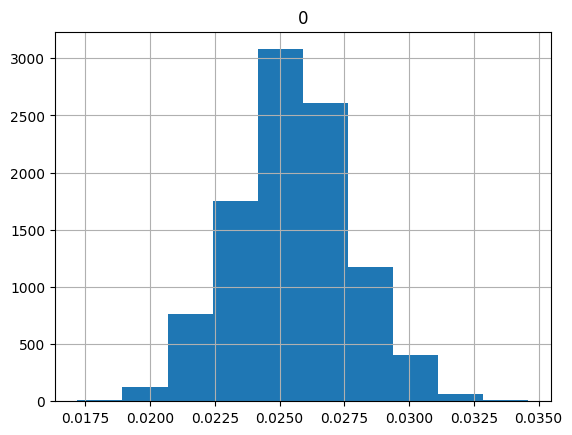

In [13]:
bootstrap_ad.hist()

In [14]:
#Посчитаем средние значения конверсии на 10000 итерации при выборке в 5000 и отобразим распределение на гистограмме, для тестовой группы
bootstrap_psa=[]


for i in range (10000):
    boot_mean_psa=psa_data.sample(n=5000,replace=True)['converted'].mean()
    bootstrap_psa.append(boot_mean_psa)
    

bootstrap_psa=pd.DataFrame(bootstrap_psa)

array([[<Axes: title={'center': '0'}>]], dtype=object)

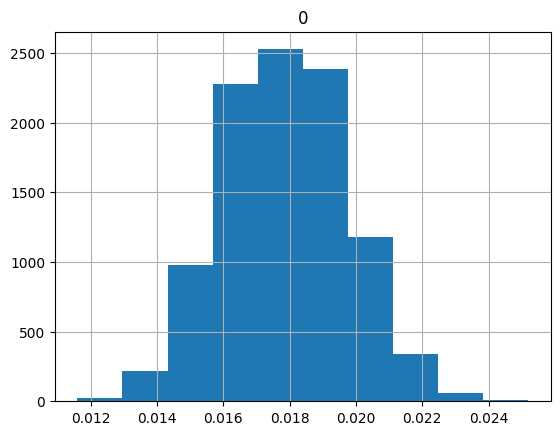

In [15]:
bootstrap_psa.hist()

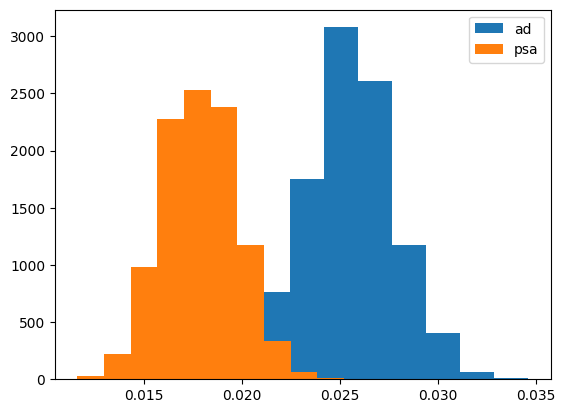

In [19]:
#Отрисовка двух гистограмм для визуального представления распределения конверсии для контрольной(ad) и тестовой группы(psa)
plt.hist(bootstrap_ad, label='ad')
plt.hist(bootstrap_psa, label='psa')
plt.legend()
plt.show()

Теперь, когда данные бутстрапированны, и визуально распределенны нормально, можно провести t-test для двух переменных и сформулировать две гипотезы. Нулевую - данные статистически не различимы. И альтернативную - данные статистически различимы.


Шаг 1:
В двухвыборочном t-тесте нулевая гипотеза утверждает, что нет никакой разницы между покупками ваших двух групп. Альтернативная гипотеза утверждает обратное: существует разница между средствами ваших двух групп.

Вот гипотезы:
Нулевая гипотеза (H₀): Реклама неэффективна для увеличения покупок продукции.

Альтернативная гипотеза (Hₐ): Реклама эффективна для увеличения покупок продукции.

Шаг 2:
Выберите уровень значимости Уровень значимости — это порог, при котором вы будете считать результат статистически значимым. Это вероятность отклонения нулевой гипотезы, когда она верна. Я использовал стандартный уровень 5% или 0,05.

Шаг 3:
Найдите значение p, я использовал метод библиотеки scipy Python для вычисления значения p.

In [17]:
t_statistic, t_p_value = stats.ttest_ind(bootstrap_ad, bootstrap_psa, alternative='greater', equal_var=True)

print("T-statistic:", t_statistic)
print("P-value:", t_p_value)

T-statistic: [263.23197947]
P-value: [0.]


Значение p-value меньше 0,05 значит можно отвергнуть нулевую гипотезу, и сделать вывод, что рекламная компания была эфективной и увеличила конверсию покупок